## Overturning circulation streamfunction and heat function in temperature-latitude space

Following the theory described by Holmes et al. (2019) doi:10.1029/2019GL085160

We calculate the streamfunction, which calculates meridional volume transport below an isotherm of temperature $\Theta$ and the heat function that does the same for meridional heat transport. In this we can obesrve global ocean overturning and heat transport.

$$ \Psi(\phi,\Theta,t) = \int \int_{\Theta '(x,\phi,z,t)<\Theta}v(x,\phi,z,t)dxdz$$
 
 $$ \mathcal{A}_I(\phi,\Theta,t) = -\rho_0C_p \int_{-\infty}^{\Theta}\Psi d\Theta ' + \mathcal{A}_D$$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client
from collections import OrderedDict


In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:45809 Dashboard: /proxy/46313/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
expt = '1deg_jra55_ryf_RCPcont'
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')
start_time='2900-01-31'
end_time = '2910-01-01'

In [4]:
psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

# ty_trans_nrho -> transport within temperature intervals 
# neutral_rho, neutral.
#

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_nrho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psiGM = psiGM.sum('grid_xt_ocean')
    psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time)#.isel(time = np.arange(40,50))
    psisubmeso = psisubmeso.sum('grid_xt_ocean')

else:
    GM = False

In [5]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)
    psisubmeso = psisubmeso / (1e6*rho)

In [6]:
psi_avg_cont = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
if GM:
    psi_avg_cont = psi_avg_cont + psiGM.mean('time')+ psisubmeso.mean('time')
    
psi_avg_cont.load()

<xarray.DataArray (neutral: 74, grid_yu_ocean: 300)>
array([[ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  5.2867783e-03,  1.1512632e-02, ...,
         1.1411706e-02,  1.5875528e-02,  6.6347539e-08],
       [ 0.0000000e+00,  3.4108356e-01,  2.9121554e-01, ...,
        -1.7166778e-01, -7.2749920e-02, -7.7586961e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75

note doesn't do correct zonal averaging north of 65N

In [17]:
expt = '1deg_jra55_ryf_RCPcont'

SST_max = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
SST_min = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
SST_mean = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).mean('time').mean('xt_ocean') -273.15
SST_mean.coords['yt_ocean'] = psi_avg_cont.grid_yu_ocean.values
SST_mean = SST_mean.rename({'yt_ocean':'grid_yu_ocean'})

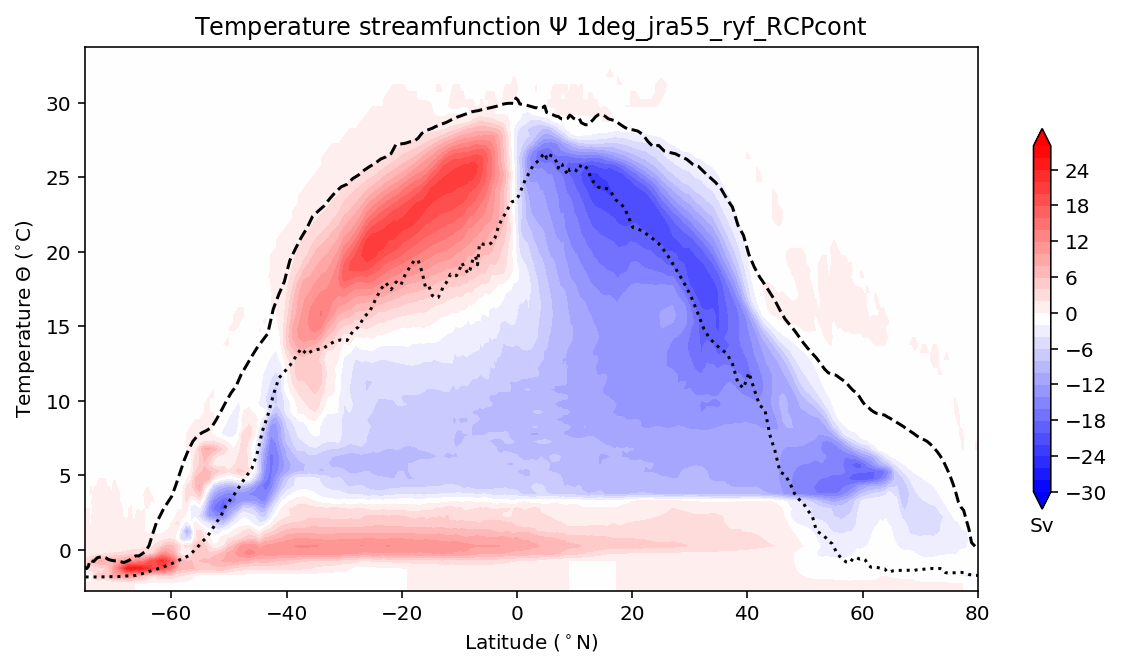

In [18]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-30,30,2)
plt.contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap='bwr', levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')

cb.ax.set_xlabel('Sv')
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=clev, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Temperature streamfunction $\Psi$ %s' % expt);
#plt.savefig('figures/overturning')

Now calculate internal heat function  $\mathcal{A}_I(\phi, \Theta, t)=\rho_0C_p \int_{-\infty }^{\Theta} \Psi d\Theta ' + \mathcal{A}_D$?

Need to also mask out where sea surface stops so we don't cumsum over air. Use the streamfunction as a mask.

In [19]:
rho_0 = 1030#kg/m^3
c_p = 3992 
A_I = -rho_0*c_p*psi_avg_cont.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
A_I = A_I/10**9 # convert to PW
A_I_c = A_I
A_I = A_I.where(psi_avg_cont !=0).fillna(0)

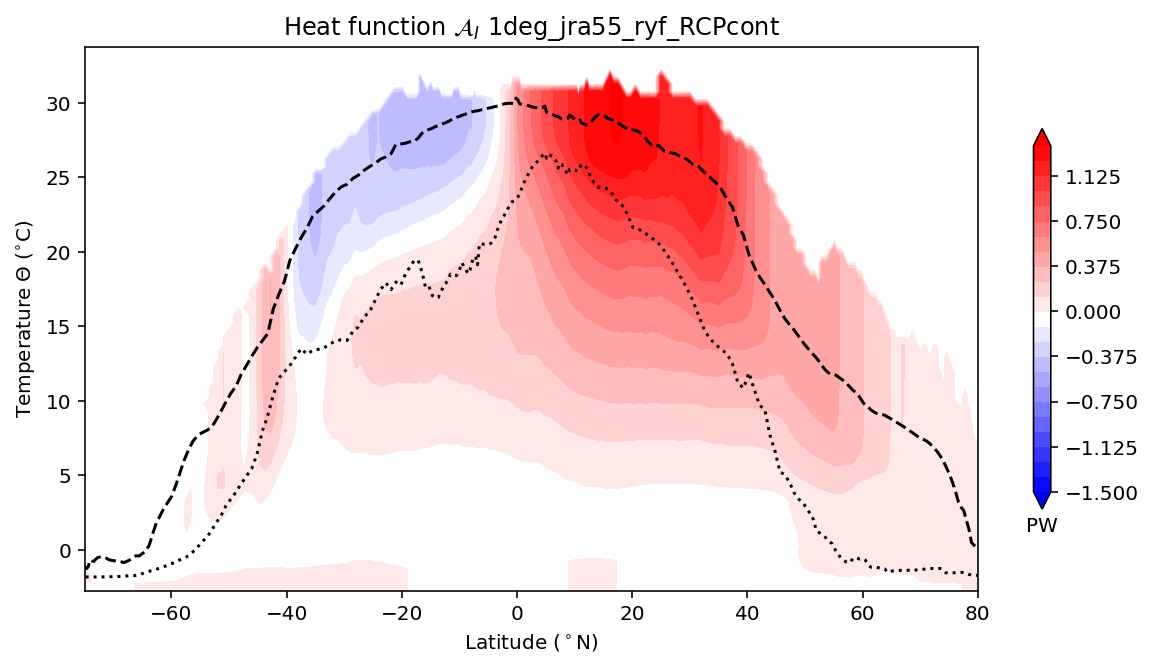

In [20]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-1.5,1.5,0.125)
plt.contourf(A_I.grid_yu_ocean,A_I.neutral, A_I, cmap='bwr', levels=clev, extend='both')
SST_min.plot(color = 'k', linestyle = 'dotted')
SST_max.plot(color = 'k', linestyle = '--')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('PW')
clev2 = np.arange(-1.5,1.5,0.25)
#plt.contour(A_I.grid_yu_ocean, A_I.neutral, A_I, levels=clev2, colors='k', linewidths=0.25)
#plt.contour(psi_avg_cont.grid_yu_ocean, psi_avg_cont.neutral, psi_avg_cont, levels=[0.0,], colors='k', linewidths=0.5)
#plt.gca().invert_yaxis()

#plt.ylim((33.75,-2.75))
plt.ylabel('Temperature $\Theta $ ($^{\circ}$C)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Heat function $\mathcal{A}_I$ %s' % expt);
#plt.savefig('figures/overturning')

The heat function maximum can be used to estimate meridional heat tranport in PW by taking the values at the surface

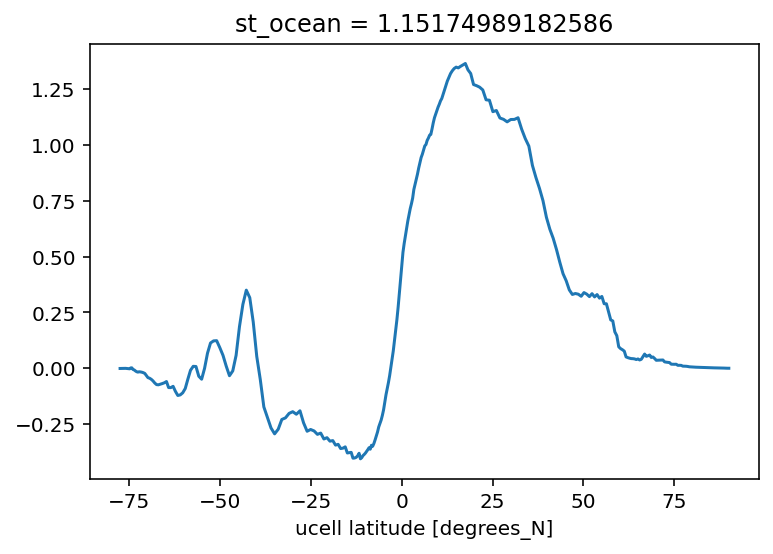

In [22]:
A_I_m = A_I.where(A_I.neutral > SST_mean-0.25).where(A_I.neutral < SST_mean+0.25).mean('neutral').plot()#.fillna(0)

Define a better cmap that has white at the centre

In [30]:
def custom_div_cmap(numcolors=21, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap


# Defining masks for basins

In [25]:
expt = '1deg_jra55_ryf_RCPcont'
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

In [26]:
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})



# Define functions to make life easier when calculating anomalies

In [27]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])

In [28]:
    def heatfunc(ekey,start_time,end_time, masktrue, mask): #masktrue means it will use a mask, either atlantic_sector_mask or indo_sector_mask.
        # to calculate global plots, choose masktrue= False mask=None
        # You can choose your own start and end times in the form '29xx-01-01'
        expt = exptdict[ekey]['expt']

        if masktrue == False:
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psi = psi.sum('grid_xt_ocean')
            
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psiGM = (psiGM).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psisubmeso = (psisubmeso).sum('grid_xt_ocean')
            
        else:
            
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psi = psi*mask
            psi = psi.sum('grid_xt_ocean')
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psiGM = (psiGM*mask).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time, end_time = end_time).sel(time = slice(start_time,end_time))
            psisubmeso = (psisubmeso*mask).sum('grid_xt_ocean')

    
        rho = 1025 # mean density of sea-water in kg/m^3
        psi = psi / (1e6*rho) # converts kg/s to Sv
        psiGM = psiGM / (1e6*rho)
        psisubmeso = psisubmeso / (1e6*rho)

        psi_avg = psi.cumsum('neutral').mean('time') - psi.sum('neutral').mean('time')
        psi_avg = psi_avg + psiGM.mean('time')+ psisubmeso.mean('time')
        psi_avg.load()

        SST_max = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).max('time').max('xt_ocean') -273.15#.isel(time = np.arange(40,50))
        SST_min = cc.querying.getvar(expt,'temp',session, ncfile = 'ocean.nc', start_time = start_time, end_time = end_time).isel(st_ocean = 0).min('time').min('xt_ocean') -273.15
    
    

        rho_0 = 1030#kg/m^3
        c_p = 3992 
        A_I = -rho_0*c_p*psi_avg.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
        A_I = A_I/10**9 # convert to PW
        #A_I_contatlantic= (A_I_contatlantic).where(psi_avg_contatlantic!=0).fillna(0)
        return psi_avg, A_I, SST_min, SST_max

# 
# Results for the 50th year, no basin selected
# 

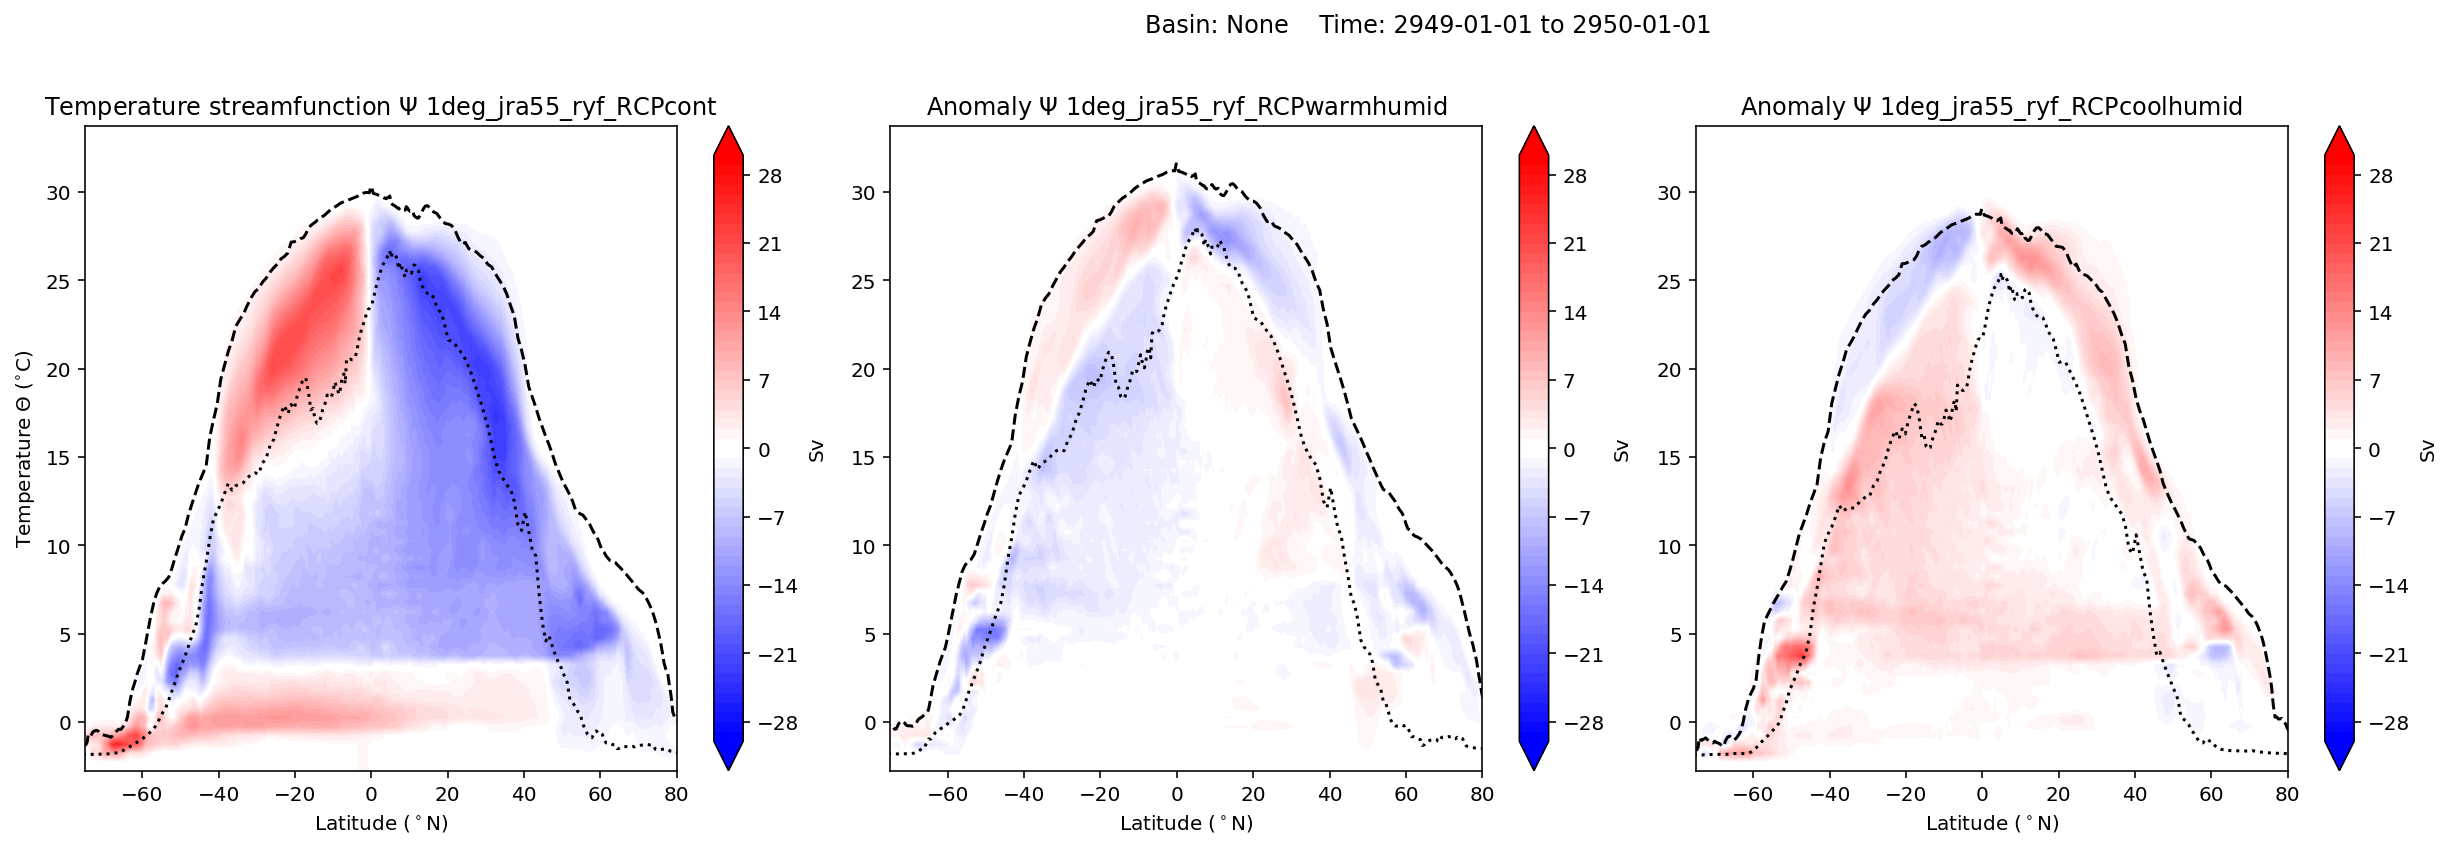

In [31]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
start_time = '2949-01-01'
end_time = '2950-01-01'
basin = atlantic_sector_mask
psi_avg_cont, A_I_cont, Sminc, Smaxc = heatfunc('Control',start_time,end_time, False, basin)
psi_avg_warm, A_I_warm,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, False, basin)
psi_avg_cool, A_I_cool,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, False, basin)
plt.suptitle('Basin: '+'None'+'    Time: '+start_time+' to '+end_time)
expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
cs2 = axes[1].contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).neutral, (psi_avg_warm-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).neutral, (psi_avg_cool-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

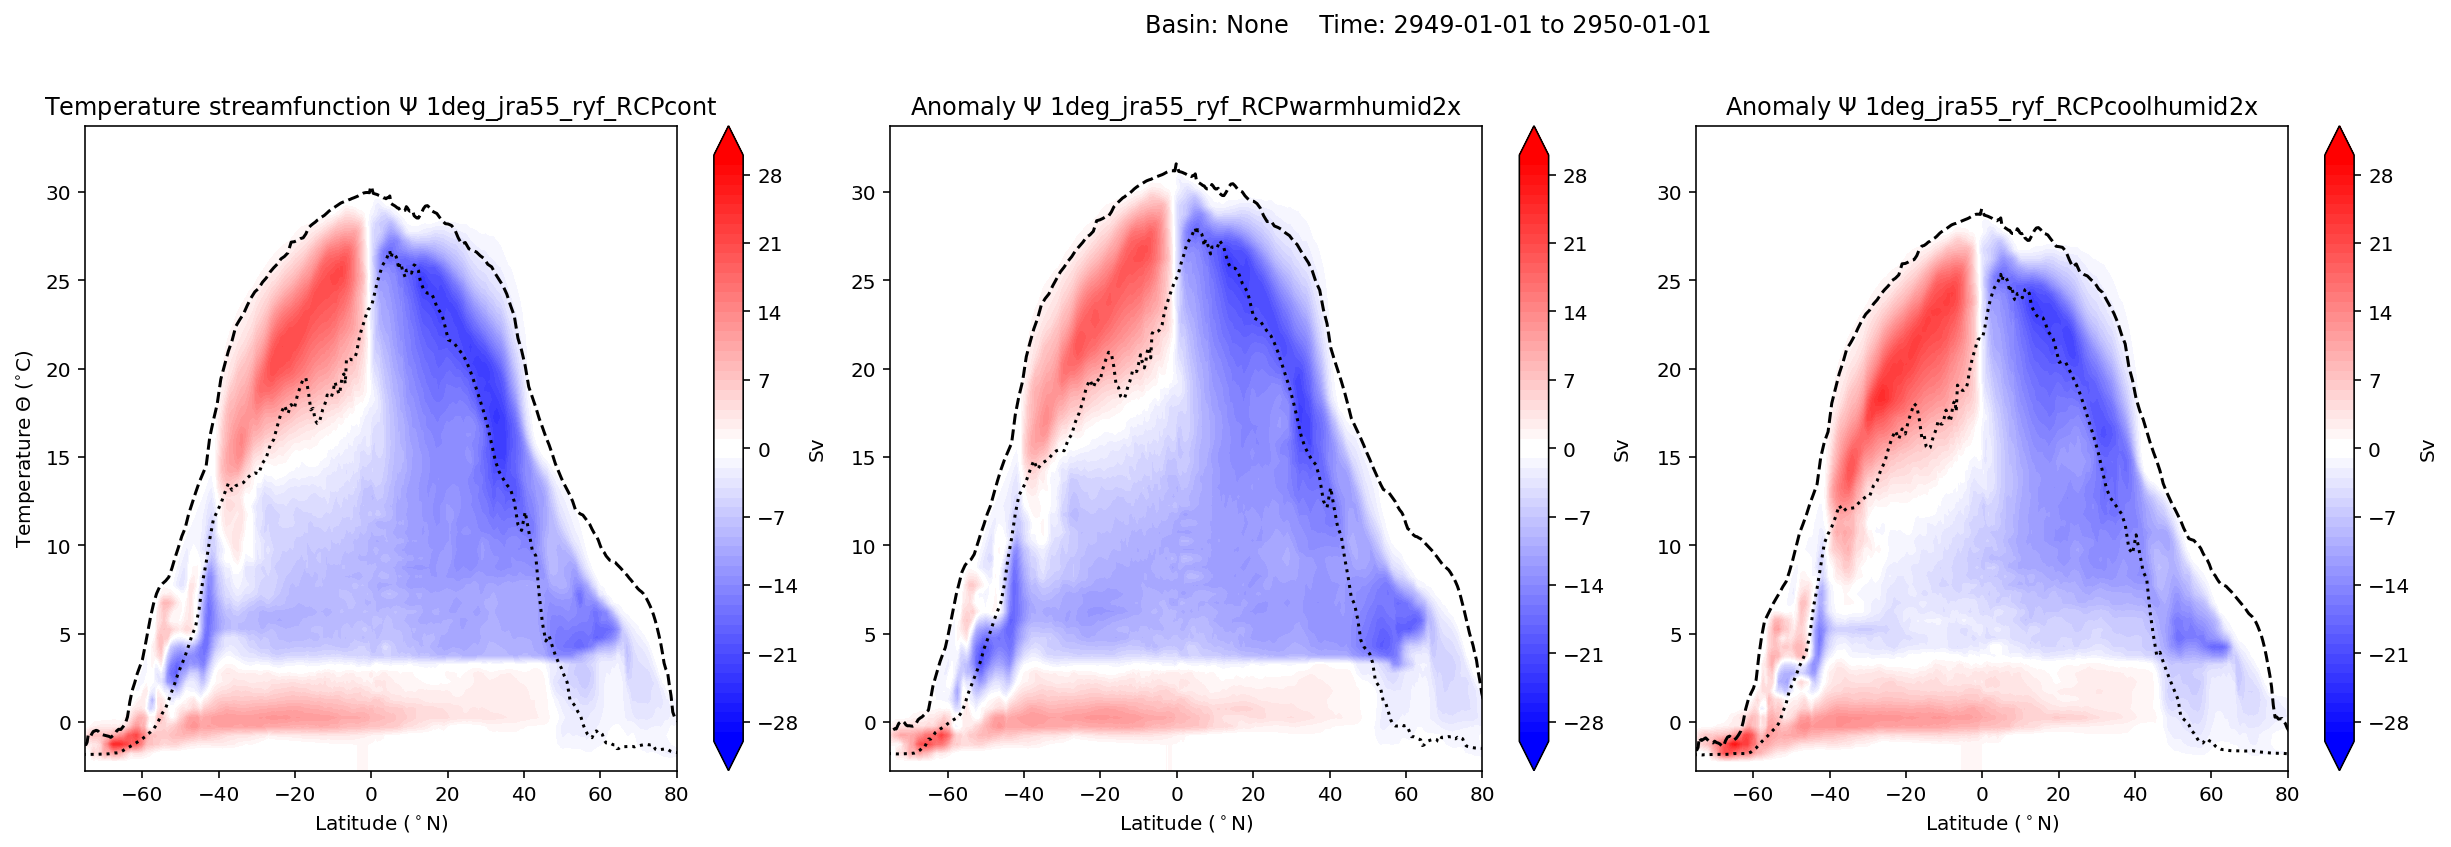

In [33]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
start_time = '2949-01-01'
end_time = '2950-01-01'
basin = None
masktrue = False
psi_avg_cont, A_I_cont, Sminc, Smaxc = heatfunc('Control',start_time,end_time, masktrue,basin)
psi_avg_warm, A_I_warm,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, masktrue,basin)
psi_avg_cool, A_I_cool,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, masktrue,basin)
plt.suptitle('Basin: '+str(basin)+'    Time: '+start_time+' to '+end_time)
expt = '1deg_jra55_ryf_RCPcont'
n=21
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
#clev = np.arange(-1.5,1.55,0.125)
cs = axes[0].contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
bwr_custom = custom_div_cmap(19)
expt = '1deg_jra55_ryf_RCPwarmhumid2x'

#clev = np.arange(-0.5,0.52,0.05)
bwr_custom = custom_div_cmap(59)
clev = np.linspace(-30,30,61)
cs2 = axes[1].contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).neutral, (psi_avg_warm), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'Sv')

expt = '1deg_jra55_ryf_RCPcoolhumid2x'

#clev = np.arange(-0.5,0.52,0.05)
cs3 = axes[2].contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).neutral, (psi_avg_cool), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Anomaly $\Psi$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

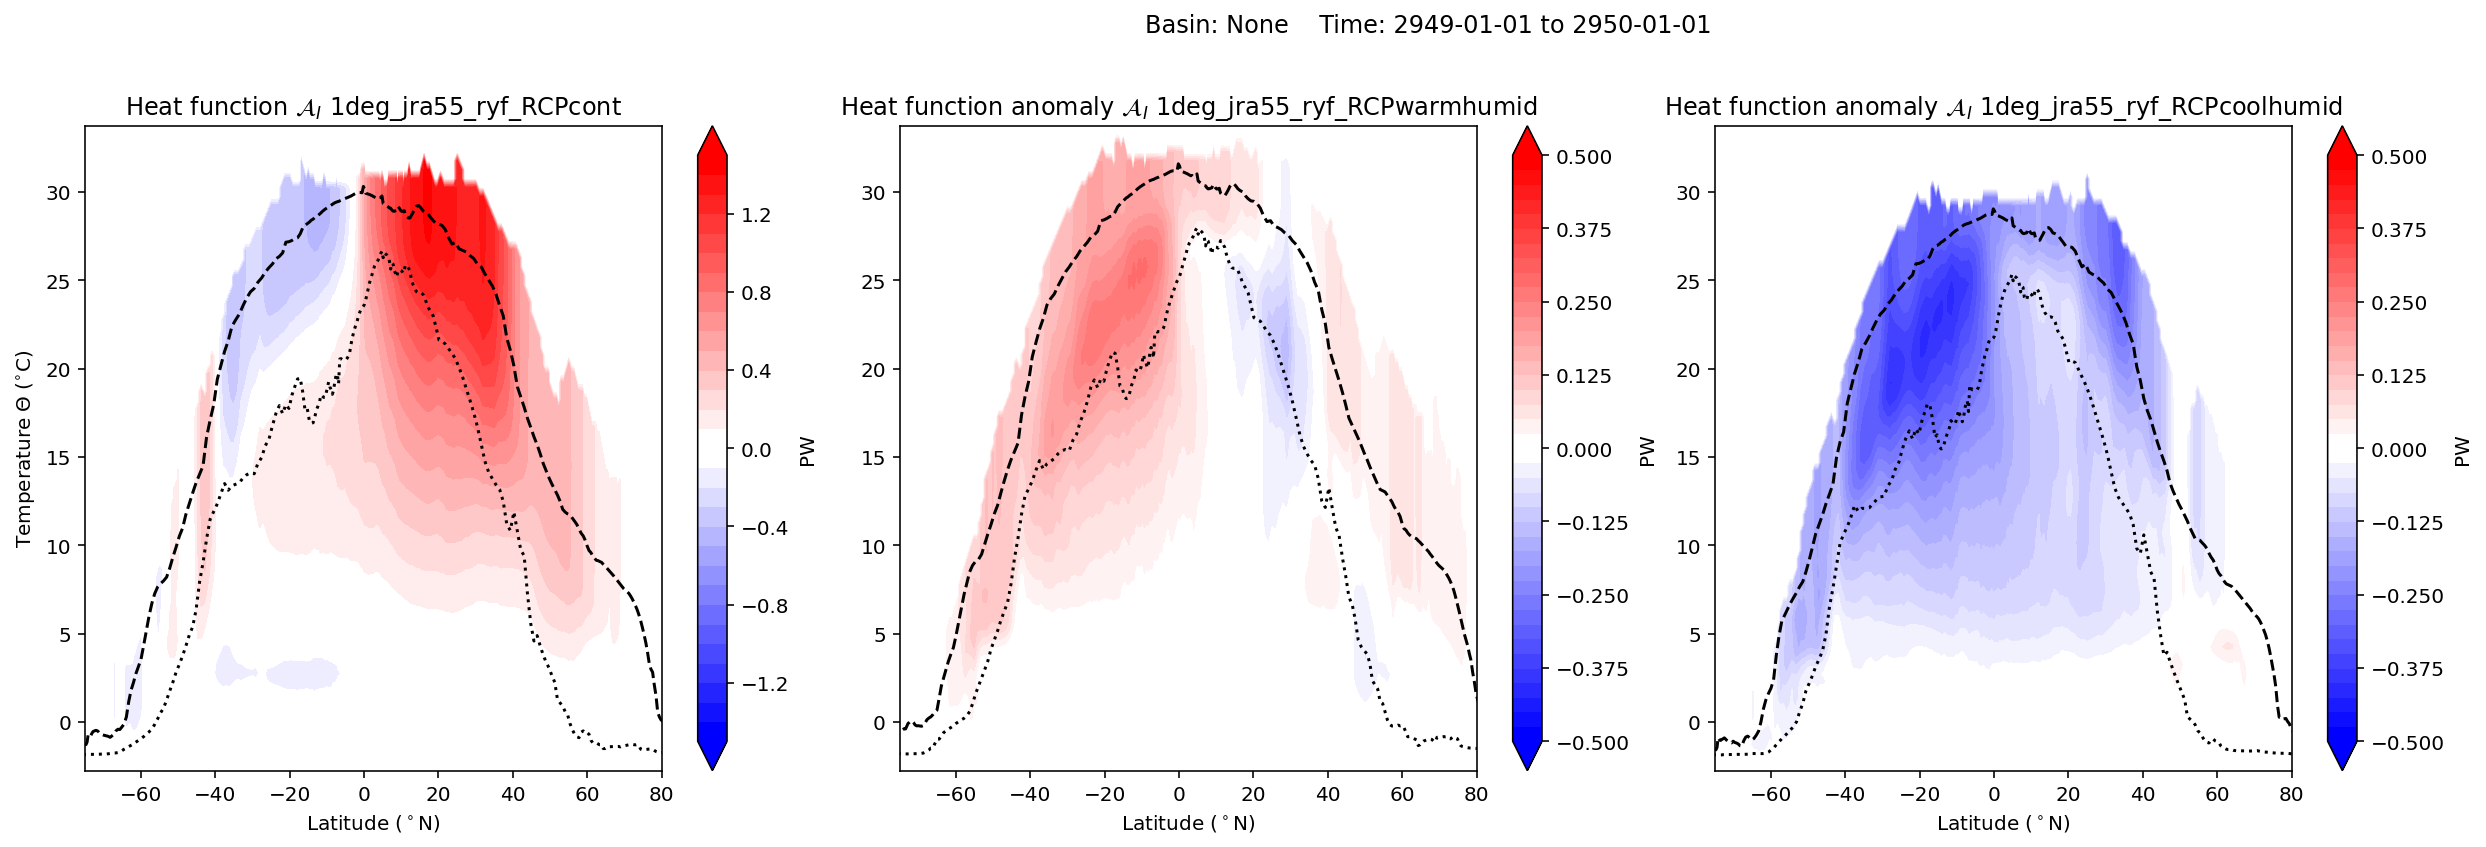

In [35]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
start_time = '2949-01-01'
end_time = '2950-01-01'
basin = None
psi_avg_cont, A_I_c, Sminc, Smaxc = heatfunc('Control',start_time,end_time, False, basin)
psi_avg_warm, A_I_w,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, False, basin)
psi_avg_cool, A_I_co,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, False, basin)

A_I_coa= (A_I_co-A_I_c).where(psi_avg_cool!=0).fillna(0)
A_I_wa= (A_I_w-A_I_c).where(psi_avg_warm!=0).fillna(0)
A_I_ca= (A_I_c).where(psi_avg_cont!=0).fillna(0)

plt.suptitle('Basin: '+str(basin)+'    Time: '+start_time+' to '+end_time)

expt = '1deg_jra55_ryf_RCPcont'
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
cs = axes[0].contourf(A_I_ca.grid_yu_ocean,A_I_ca.neutral, A_I_ca, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

expt = '1deg_jra55_ryf_RCPwarmhumid'
bwr_custom = custom_div_cmap(39)
clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
cs2 = axes[1].contourf((A_I_wa).grid_yu_ocean,(A_I_wa).neutral, (A_I_wa), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
cs3 = axes[2].contourf((A_I_coa).grid_yu_ocean,(A_I_coa).neutral, (A_I_coa), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function anomaly $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

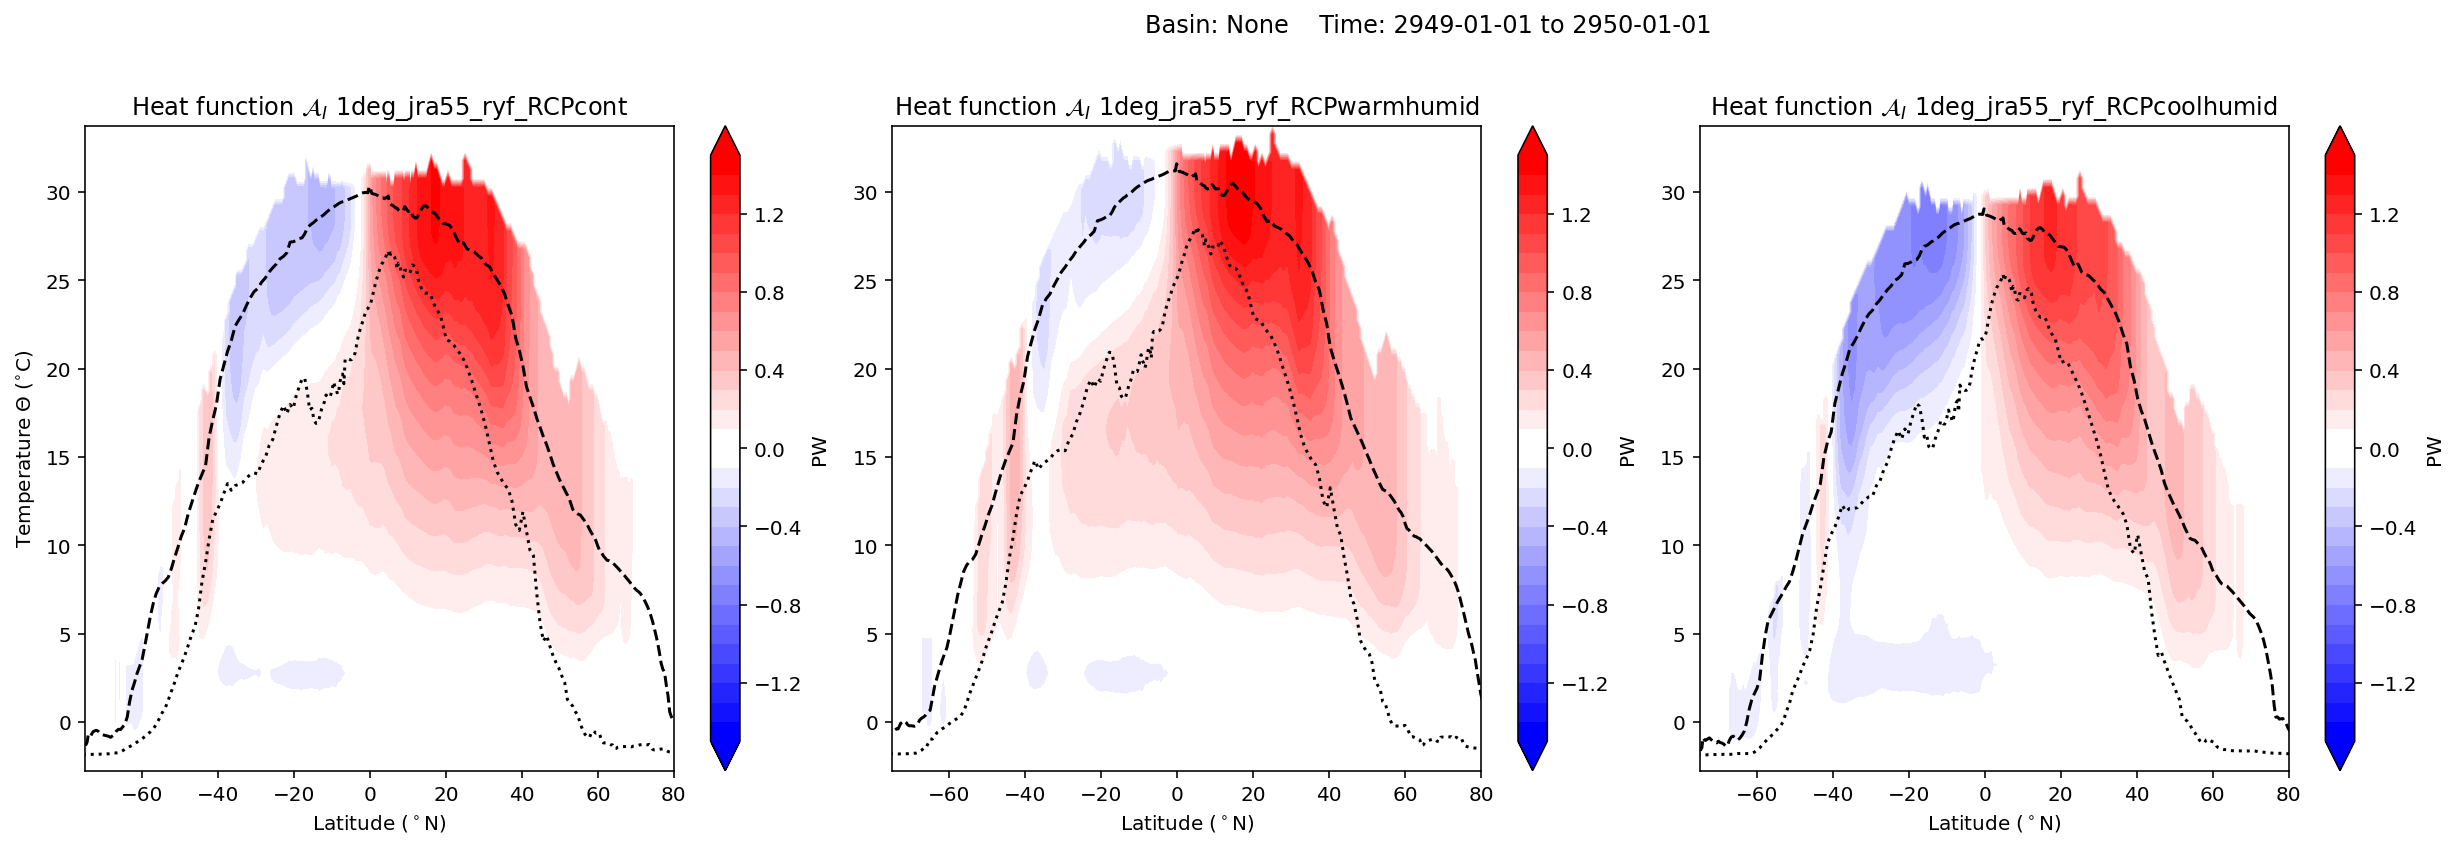

In [38]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (20,6))
start_time = '2949-01-01'
end_time = '2950-01-01'
basin = None
psi_avg_cont, A_I_c, Sminc, Smaxc = heatfunc('Control',start_time,end_time, False, basin)
psi_avg_warm, A_I_w,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, False, basin)
psi_avg_cool, A_I_co,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, False, basin)

A_I_coa= (A_I_co-A_I_c).where(psi_avg_cool!=0).fillna(0)
A_I_wa= (A_I_w-A_I_c).where(psi_avg_warm!=0).fillna(0)
A_I_ca= (A_I_c).where(psi_avg_cont!=0).fillna(0)
A_I_wm= (A_I_w).where(psi_avg_warm!=0).fillna(0)
A_I_com= (A_I_co).where(psi_avg_cool!=0).fillna(0)


plt.suptitle('Basin: '+str(basin)+'    Time: '+start_time+' to '+end_time)

expt = '1deg_jra55_ryf_RCPcont'
bwr_custom = custom_div_cmap(29)
clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
cs = axes[0].contourf(A_I_ca.grid_yu_ocean,A_I_ca.neutral, A_I_ca, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-75,80])
axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

expt = '1deg_jra55_ryf_RCPwarmhumid'
#bwr_custom = custom_div_cmap(29)
#clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
cs2 = axes[1].contourf((A_I_wm).grid_yu_ocean,(A_I_wm).neutral, (A_I_wm), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[1].set_ylabel('')
axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-75,80])
axes[1].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs2, ax=axes[1], label = 'PW')

expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
cs3 = axes[2].contourf((A_I_com).grid_yu_ocean,(A_I_com).neutral, (A_I_com), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
axes[2].set_ylabel('')
axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-75,80])
axes[2].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
fig.colorbar(cs3, ax=axes[2], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
plt.tight_layout()
plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

# Automatic plotting

I have left in the non-automated plotting as it is easier to change a single plot's features using the above. However, I have also defined automatic plotting functions.


In [32]:
def plot_psi_anom_x1(start_time,end_time,basinTrue, basin,title):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize = (20,6))
    #start_time = '2900-01-01'
    #end_time = '2901-01-01'
    #basin = atlantic_sector_mask
    psi_avg_cont, A_I_cont, Sminc, Smaxc = heatfunc('Control',start_time,end_time, basinTrue, basin)
    psi_avg_warm, A_I_warm,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, basinTrue, basin)
    psi_avg_cool, A_I_cool,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, basinTrue, basin)
    plt.suptitle('Basin: '+title+'    Time: '+start_time+' to '+end_time)
    expt = '1deg_jra55_ryf_RCPcont'
    n=21
    bwr_custom = custom_div_cmap(59)
    clev = np.linspace(-30,30,61)
    #clev = np.arange(-1.5,1.55,0.125)
    cs = axes[0].contourf(psi_avg_cont.grid_yu_ocean,psi_avg_cont.neutral, psi_avg_cont, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
    Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
    Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
    #cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
    axes[0].set_xlabel('Latitude ($^\circ$N)')
    axes[0].set_xlim([-75,80])
    axes[0].set_title('Temperature streamfunction $\Psi$ %s' % expt);
    fig.colorbar(cs, ax=axes[0], label = 'Sv')
#plt.savefig('figures/overturning')
    bwr_custom = custom_div_cmap(19)
    expt = '1deg_jra55_ryf_RCPwarmhumid'

#clev = np.arange(-0.5,0.52,0.05)
    bwr_custom = custom_div_cmap(59)
    clev = np.linspace(-30,30,61)
    cs2 = axes[1].contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).neutral, (psi_avg_warm-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
    Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
    Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Latitude ($^\circ$N)')
    axes[1].set_xlim([-75,80])
    axes[1].set_title('Anomaly $\Psi$ %s' % expt);
    fig.colorbar(cs2, ax=axes[1], label = 'Sv')

    expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.52,0.05)
    cs3 = axes[2].contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).neutral, (psi_avg_cool-psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
    Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
    Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('Latitude ($^\circ$N)')
    axes[2].set_xlim([-75,80])
    axes[2].set_title('Anomaly $\Psi$ %s' % expt);
    fig.colorbar(cs3, ax=axes[2], label = 'Sv')

    cs3 = axes[3].contourf((psi_avg_cool+psi_avg_warm-2*psi_avg_cont).grid_yu_ocean,(psi_avg_cool+psi_avg_warm-2*psi_avg_cont).neutral, (psi_avg_cool+psi_avg_warm-2*psi_avg_cont), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True, vcenter=0)
#Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
#Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[3].set_ylabel('')
    axes[3].set_xlabel('Latitude ($^\circ$N)')
    axes[3].set_xlim([-75,80])
    axes[3].set_title('Sum of Anomalies $\Psi$');
    fig.colorbar(cs3, ax=axes[3], label = 'Sv')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

In [33]:
def plot_A_I_anom_x1(start_time,end_time,basinTrue, basin,title):

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize = (20,6))
#start_time = '2900-01-01'
#end_time = '2901-01-01'
#basin = None
    psi_avg_cont, A_I_c, Sminc, Smaxc = heatfunc('Control',start_time,end_time, basinTrue, basin)
    psi_avg_warm, A_I_w,Sminw,Smaxw = heatfunc('Warming',start_time,end_time, basinTrue, basin)
    psi_avg_cool, A_I_co,Sminco,Smaxco = heatfunc('Cooling',start_time,end_time, basinTrue, basin)
    
    plt.suptitle('Basin: '+title+'    Time: '+start_time+' to '+end_time)

    expt = '1deg_jra55_ryf_RCPcont'
    bwr_custom = custom_div_cmap(29)
    clev = np.linspace(-1.5,1.5,31)
#clev = np.arange(-1.5,1.51,0.125)
    cs = axes[0].contourf(A_I_c.grid_yu_ocean,A_I_c.neutral, A_I_c, cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
    Sminc.plot(color = 'k', linestyle = 'dotted', ax = axes[0])
    Smaxc.plot(color = 'k', linestyle = '--', ax = axes[0])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[0].set_ylabel('Temperature $\Theta $ ($^{\circ}$C)')
    axes[0].set_xlabel('Latitude ($^\circ$N)')
    axes[0].set_xlim([-75,80])
    axes[0].set_title('Heat function $\mathcal{A}_I$ %s' % expt);
    fig.colorbar(cs, ax=axes[0], label = 'PW')
#plt.savefig('figures/overturning')

    expt = '1deg_jra55_ryf_RCPwarmhumid'
    bwr_custom = custom_div_cmap(39)
    clev = np.linspace(-0.5,0.5,41)

#clev = np.arange(-0.5,0.51,0.05)
    cs2 = axes[1].contourf((A_I_w-A_I_c).grid_yu_ocean,(A_I_w-A_I_c).neutral, (A_I_w-A_I_c), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
    Sminw.plot(color = 'k', linestyle = 'dotted', ax = axes[1])
    Smaxw.plot(color = 'k', linestyle = '--', ax = axes[1])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Latitude ($^\circ$N)')
    axes[1].set_xlim([-75,80])
    axes[1].set_title('Anomaly $\mathcal{A}_I$ %s' % expt);
    fig.colorbar(cs2, ax=axes[1], label = 'PW')

    expt = '1deg_jra55_ryf_RCPcoolhumid'

#clev = np.arange(-0.5,0.51,0.05)
    cs3 = axes[2].contourf((A_I_co-A_I_c).grid_yu_ocean,(A_I_co-A_I_c).neutral, (A_I_co-A_I_c), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
    Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[2])
    Smaxco.plot(color = 'k', linestyle = '--', ax = axes[2])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('Latitude ($^\circ$N)')
    axes[2].set_xlim([-75,80])
    axes[2].set_title('Anomaly $\mathcal{A}_I$ %s' % expt);
    fig.colorbar(cs3, ax=axes[2], label = 'PW')

    cs3 = axes[3].contourf((A_I_co+A_I_w-2*A_I_c).grid_yu_ocean,(A_I_co+A_I_w-2*A_I_c).neutral, (A_I_co+A_I_w-2*A_I_c), cmap=bwr_custom, levels=clev, extend='both', add_colorbar = True)
#Sminco.plot(color = 'k', linestyle = 'dotted', ax = axes[3])
#Smaxco.plot(color = 'k', linestyle = '--', ax = axes[3])
#cb=plt.colorbar(orientation='vertical', shrink = 0.7)
#cb.ax.set_xlabel('PW')
    axes[3].set_ylabel('')
    axes[3].set_xlabel('Latitude ($^\circ$N)')
    axes[3].set_xlim([-75,80])
    axes[3].set_title('Sum of anomaly $\mathcal{A}_I$')
    fig.colorbar(cs3, ax=axes[3], label = 'PW')


# cb_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(CS, cax=cb_ax, cmap = cm.cm.balance)
# cbar.ax.set_ylabel('heat anomaly ($Jm^{-2}$)', fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)

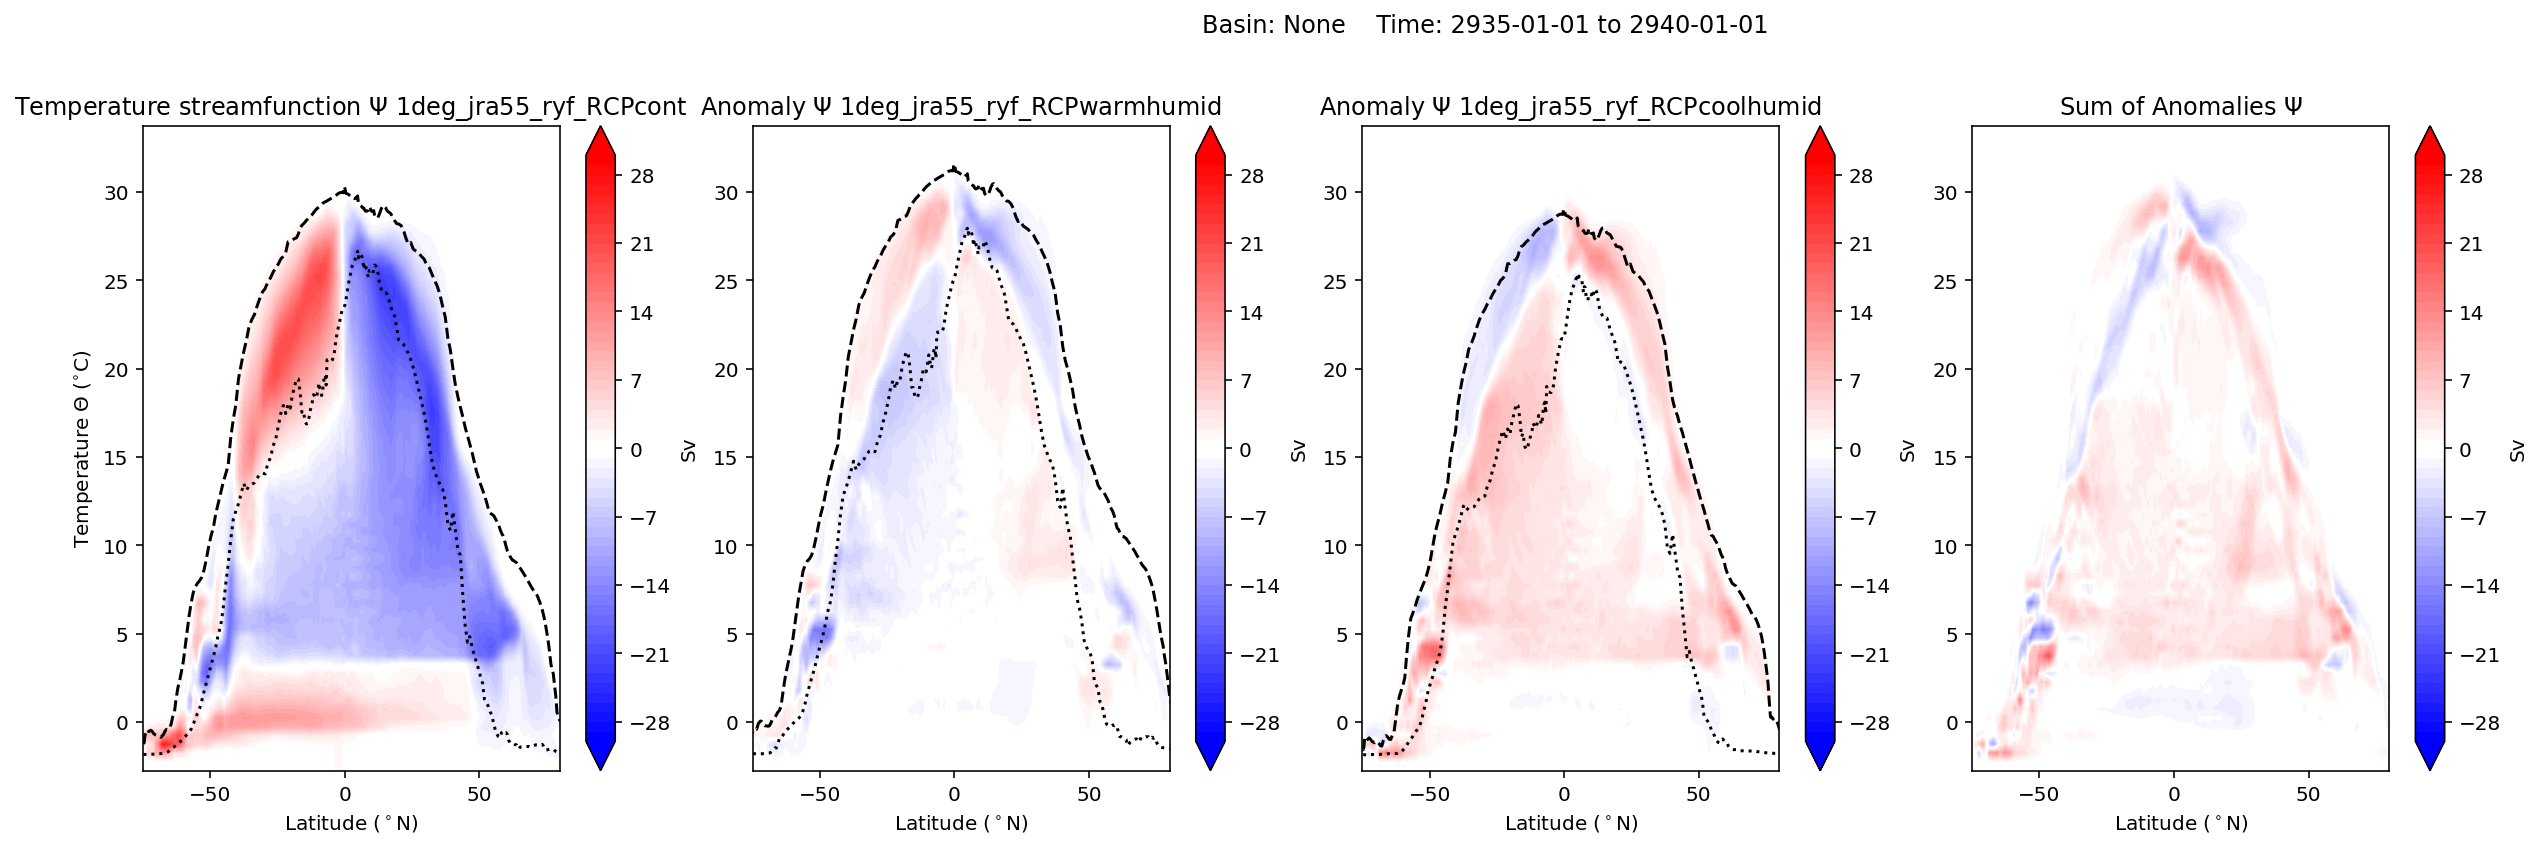

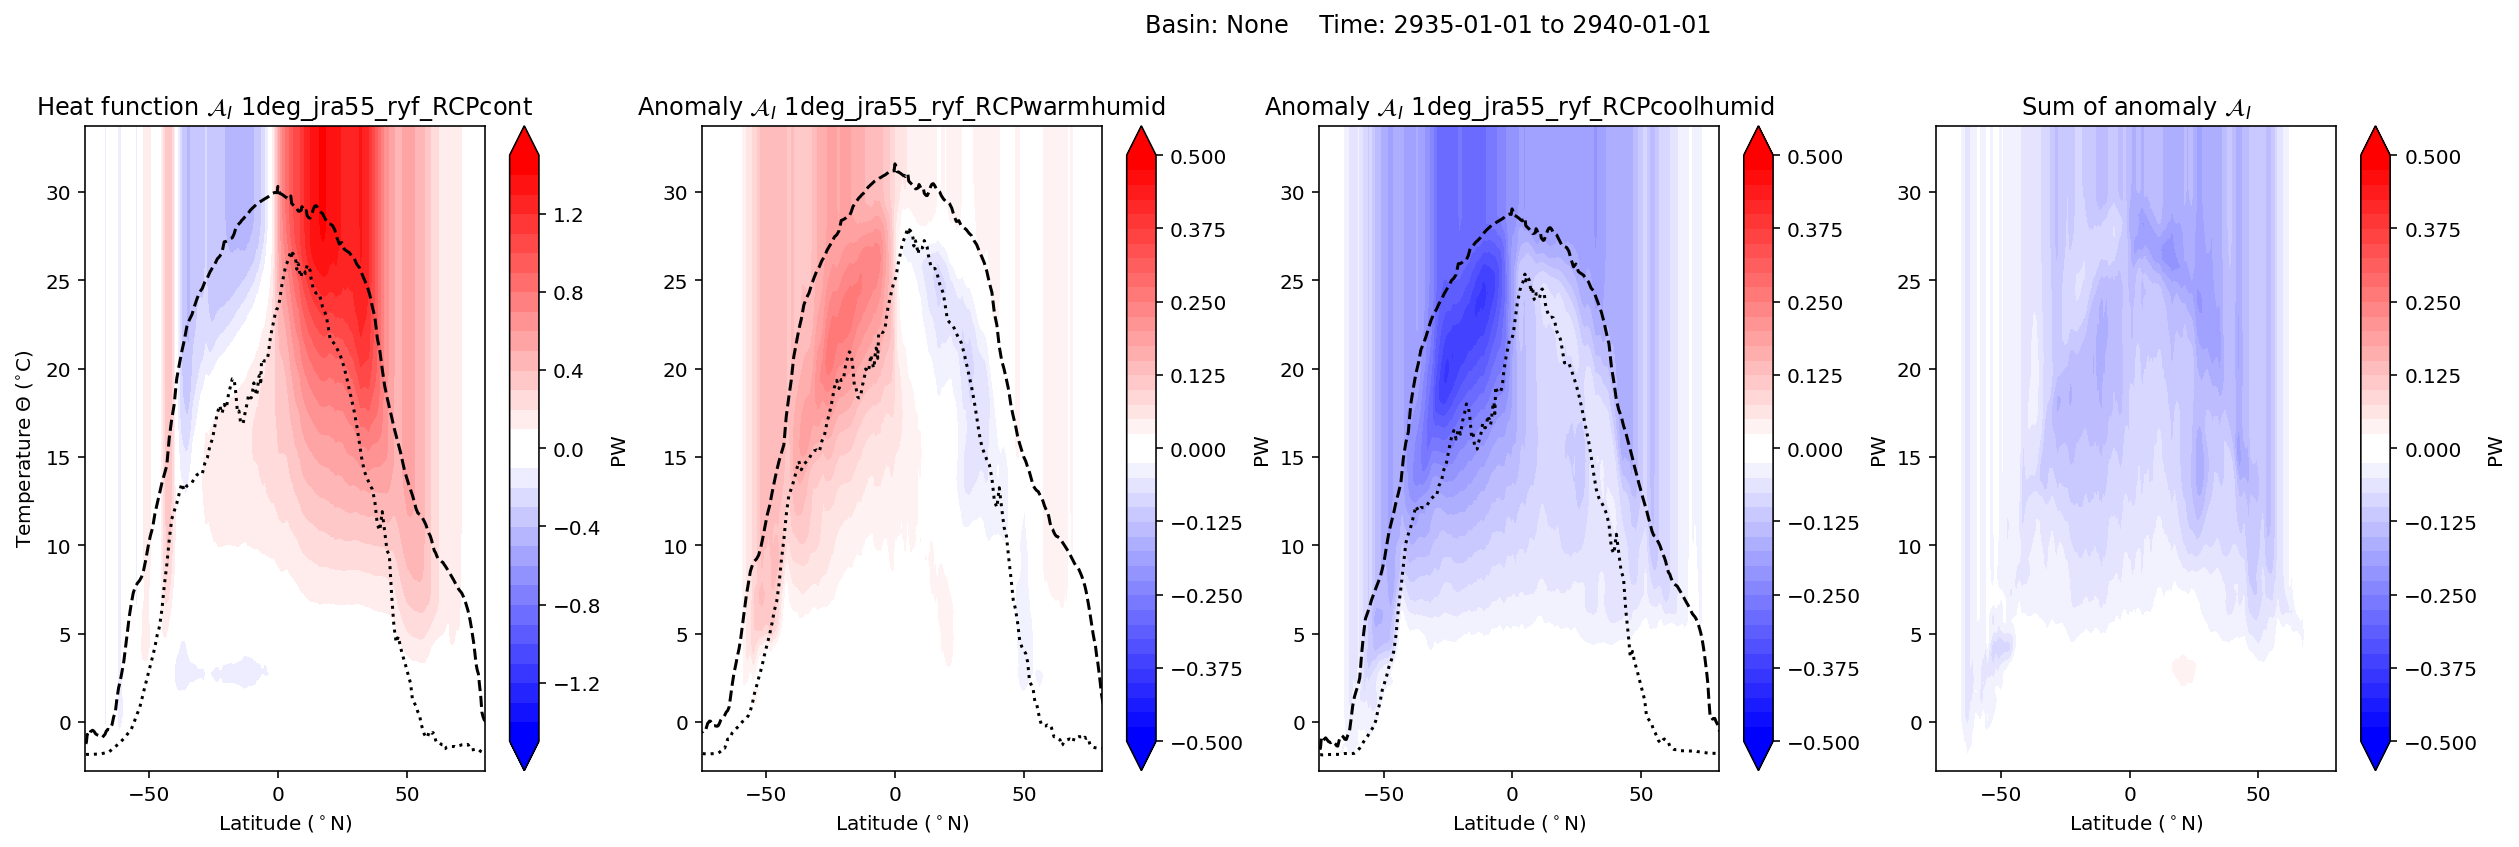

In [35]:
plot_psi_anom_x1('2935-01-01','2940-01-01',False, basin, 'None')
plt.show()
plot_A_I_anom_x1('2935-01-01','2940-01-01',False, basin, 'None')
plt.show()